In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import ttest_rel

Baseline Acc: 0.575 ± 0.022
TDA Acc:      0.592 ± 0.013
Acc t-test: t=3.147, p=0.012

Baseline AUC: 0.602 ± 0.018
TDA AUC:      0.628 ± 0.019
AUC t-test: t=6.569, p=0.000


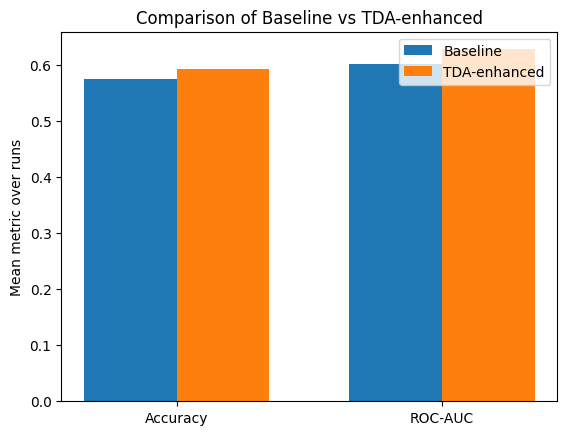

In [17]:
ticker = 'SPY'
data = yf.download(ticker, start='2018-01-01', end='2025-05-01', progress=False)
prices = data['Close'].dropna().to_numpy().flatten()

returns = np.diff(prices) / prices[:-1]
abs_returns = np.abs(returns)
vol_threshold = np.median(abs_returns) 

window_size = 90  
horizon = 1  
step = 1
n_windows = (len(returns) - window_size - horizon + 1) // step

X_feat = []
y = []
for i in range(n_windows):
    window = returns[i:i + window_size]
    future_ret = returns[i + window_size]  
    label = int(abs(future_ret) > vol_threshold)
    tech_mean = window.mean()
    tech_std = window.std()
    
    emb = np.vstack([window[:-1], window[1:]]).T
    dgms = ripser(emb, maxdim=1)['dgms']
    tda_feats = []
    for diag in dgms:
        lifespans = diag[:,1] - diag[:,0]
        if not np.all(np.isfinite(lifespans)):
            finite = lifespans[np.isfinite(lifespans)]
            lifespans = np.where(np.isfinite(lifespans), lifespans, finite.max() if finite.size else 0)
        sorted_ls = np.sort(lifespans)[::-1]
        top3 = np.pad(sorted_ls, (0, 3 - min(3, len(sorted_ls))), 'constant')[:3]
        tda_feats.extend(top3)
    X_feat.append([tech_mean, tech_std] + tda_feats)
    y.append(label)

cols = ['mean_ret', 'std_ret', 'H0_l1', 'H0_l2', 'H0_l3', 'H1_l1', 'H1_l2', 'H1_l3']
df = pd.DataFrame(X_feat, columns=cols)
df['label'] = y

runs = 10
acc_base, acc_tda = [], []
auc_base, auc_tda = [], []

for seed in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(
        df[cols], df['label'], test_size=0.3, random_state=seed, stratify=df['label']
    )
    # Baseline
    base = RandomForestClassifier(random_state=seed)
    base.fit(X_train[['mean_ret','std_ret']], y_train)
    pred_base = base.predict(X_test[['mean_ret','std_ret']])
    prob_base = base.predict_proba(X_test[['mean_ret','std_ret']])[:,1]
    acc_base.append(accuracy_score(y_test, pred_base))
    auc_base.append(roc_auc_score(y_test, prob_base))
    
    # baseline with TDA features
    tda = RandomForestClassifier(random_state=seed)
    tda.fit(X_train, y_train)
    pred_tda = tda.predict(X_test)
    prob_tda = tda.predict_proba(X_test)[:,1]
    acc_tda.append(accuracy_score(y_test, pred_tda))
    auc_tda.append(roc_auc_score(y_test, prob_tda))

t_acc, p_acc = ttest_rel(acc_tda, acc_base)
t_auc, p_auc = ttest_rel(auc_tda, auc_base)

print(f"Baseline Acc: {np.mean(acc_base):.3f} ± {np.std(acc_base):.3f}")
print(f"TDA Acc:      {np.mean(acc_tda):.3f} ± {np.std(acc_tda):.3f}")
print(f"Acc t-test: t={t_acc:.3f}, p={p_acc:.3f}\n")
print(f"Baseline AUC: {np.mean(auc_base):.3f} ± {np.std(auc_base):.3f}")
print(f"TDA AUC:      {np.mean(auc_tda):.3f} ± {np.std(auc_tda):.3f}")
print(f"AUC t-test: t={t_auc:.3f}, p={p_auc:.3f}")

labels = ['Accuracy', 'ROC-AUC']
means_base = [np.mean(acc_base), np.mean(auc_base)]
means_tda = [np.mean(acc_tda), np.mean(auc_tda)]

x = np.arange(len(labels))
width = 0.35
plt.figure()
plt.bar(x - width/2, means_base, width)
plt.bar(x + width/2, means_tda, width)
plt.xticks(x, labels)
plt.ylabel('Mean metric over runs')
plt.legend(['Baseline', 'TDA-enhanced'])
plt.title('Comparison of Baseline vs TDA-enhanced')
plt.show()

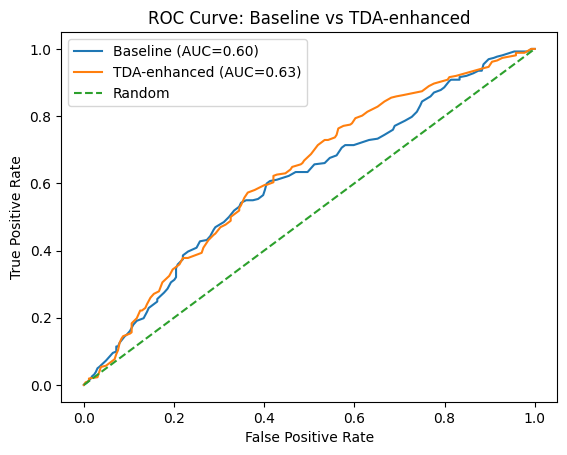

In [18]:
seed = 0
X_train, X_test, y_train, y_test = train_test_split(
    df[cols], df['label'], test_size=0.3, random_state=seed, stratify=df['label']
)

# Baseline
model_base = RandomForestClassifier(random_state=seed)
model_base.fit(X_train[['mean_ret','std_ret']], y_train)
proba_base = model_base.predict_proba(X_test[['mean_ret','std_ret']])[:,1]

# baseline with TDA features
model_tda = RandomForestClassifier(random_state=seed)
model_tda.fit(X_train, y_train)
proba_tda = model_tda.predict_proba(X_test)[:,1]

fpr_base, tpr_base, _ = roc_curve(y_test, proba_base)
roc_auc_base = auc(fpr_base, tpr_base)
fpr_tda, tpr_tda, _ = roc_curve(y_test, proba_tda)
roc_auc_tda = auc(fpr_tda, tpr_tda)

plt.figure()
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={roc_auc_base:.2f})')
plt.plot(fpr_tda, tpr_tda, label=f'TDA-enhanced (AUC={roc_auc_tda:.2f})')
plt.plot([0,1],[0,1],'--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Baseline vs TDA-enhanced')
plt.legend()
plt.show()

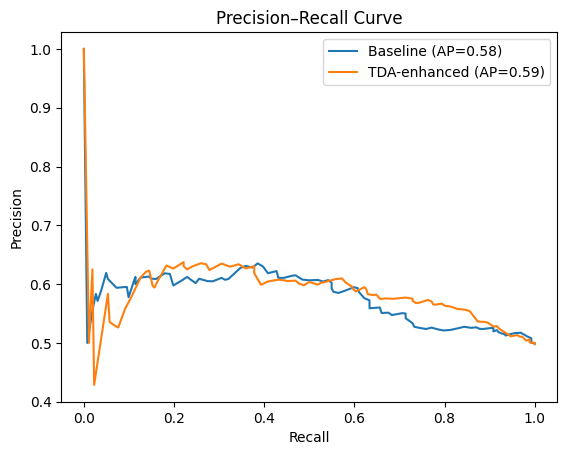

In [20]:
precision_base, recall_base, _ = precision_recall_curve(y_test, proba_base)
ap_base = average_precision_score(y_test, proba_base)

precision_tda, recall_tda, _ = precision_recall_curve(y_test, proba_tda)
ap_tda = average_precision_score(y_test, proba_tda)

plt.figure()
plt.plot(recall_base, precision_base, label=f'Baseline (AP={ap_base:.2f})')
plt.plot(recall_tda,   precision_tda,   label=f'TDA-enhanced (AP={ap_tda:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()